In [1]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [9]:
jsons = glob('../analytics-raw-data/*.json') # add your path here

In [10]:
jsons

['../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-04-01-2022-10-41-30-v3.1.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Registros-04-01-2022-10-42-10-v4.6.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-04-08-2022-12-56-05-v3.2.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Registros-04-08-2022-12-57-08-v4.7.0.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022-23-14-35-v3.0.7.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Registros-03-26-2022-18-26-26-v4.5.2.json',
 '../analytics-raw-data/fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-18-59-14-v3.3.1.json']

In [11]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021-2-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[3]

    df['version'] = aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [12]:
base_component_df = create_base_component_df(jsons)

/tmp/ipykernel_213276/595424903.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_213276/595424903.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_213276/595424903.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_213276/595424903.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_213276/595424903.py:22: FutureWarning: The frame.append method is deprecated 

In [ ]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
36,duplicated_lines_density,2.4,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
37,functions,375,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
38,security_rating,1.0,True,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
39,files,109,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
40,complexity,525,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
41,ncloc,7026,NaN,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
42,coverage,13.9,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
43,reliability_rating,1.0,True,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
44,comment_lines_density,1.6,False,fga-eps-mds-2021-2-Oraculo-FrontEnd-03-25-2022...,03,3.0.7
54,duplicated_lines_density,0.0,True,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,03,3.3.1


In [ ]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'test_errors',
               'test_failures',
               'security_rating']

len(metric_list)

10

In [ ]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"Oraculo-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [ ]:
file_component_df = create_file_df(jsons)
#file_component_df.repository.unique()
#file_component_df.head(10)

/tmp/ipykernel_212369/4289188346.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_212369/4289188346.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_212369/4289188346.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_212369/4289188346.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_212369/4289188346.py:43: FutureWarning: The frame.append method is deprec

In [ ]:
front_df = file_component_df[file_component_df['repository'] == 'FrontEnd']
profile_df = file_component_df[file_component_df['repository'] == 'Profile']
registros_df = file_component_df[file_component_df['repository'] == 'Registros']

In [ ]:
profile_df

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,test_errors,test_failures,security_rating,reliability_rating,test_success_density,filename,repository,version
377,src/Model/Department.js,3,3,0.0,0.0,80.0,33,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1
378,src/Controller/DepartmentController.js,3,6,0.0,0.0,100.0,47,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1
379,src/Utils/hash.js,1,1,0.0,0.0,100.0,6,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1
380,src/index.js,0,1,0.0,0.0,87.0,23,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1
381,src/Database/index.js,7,12,1.4,0.0,100.0,71,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1
382,src/Utils/JWT.js,2,4,0.0,0.0,100.0,19,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1
383,src/Model/Level.js,2,2,0.0,0.0,100.0,22,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1
384,src/routes.js,0,0,0.0,0.0,100.0,18,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1
385,src/Model/User.js,2,2,0.0,0.0,100.0,29,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1
386,src/Controller/UserController.js,10,30,0.9,0.0,91.4,211,0,0,1.0,1.0,100.0,fga-eps-mds-2021-2-Oraculo-Profile-03-27-2022-...,Profile,03-27-2022-18-59-14-v3.3.1


In [ ]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

In [ ]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

In [ ]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

In [ ]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

In [ ]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

In [ ]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

In [ ]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

In [ ]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m3(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m3_list,
                               'm5': m3_list,
                               'm6': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [ ]:
front_metrics = create_metrics_df(front_df)
profile_metrics = create_metrics_df(profile_df)
registros_metrics = create_metrics_df(registros_df)

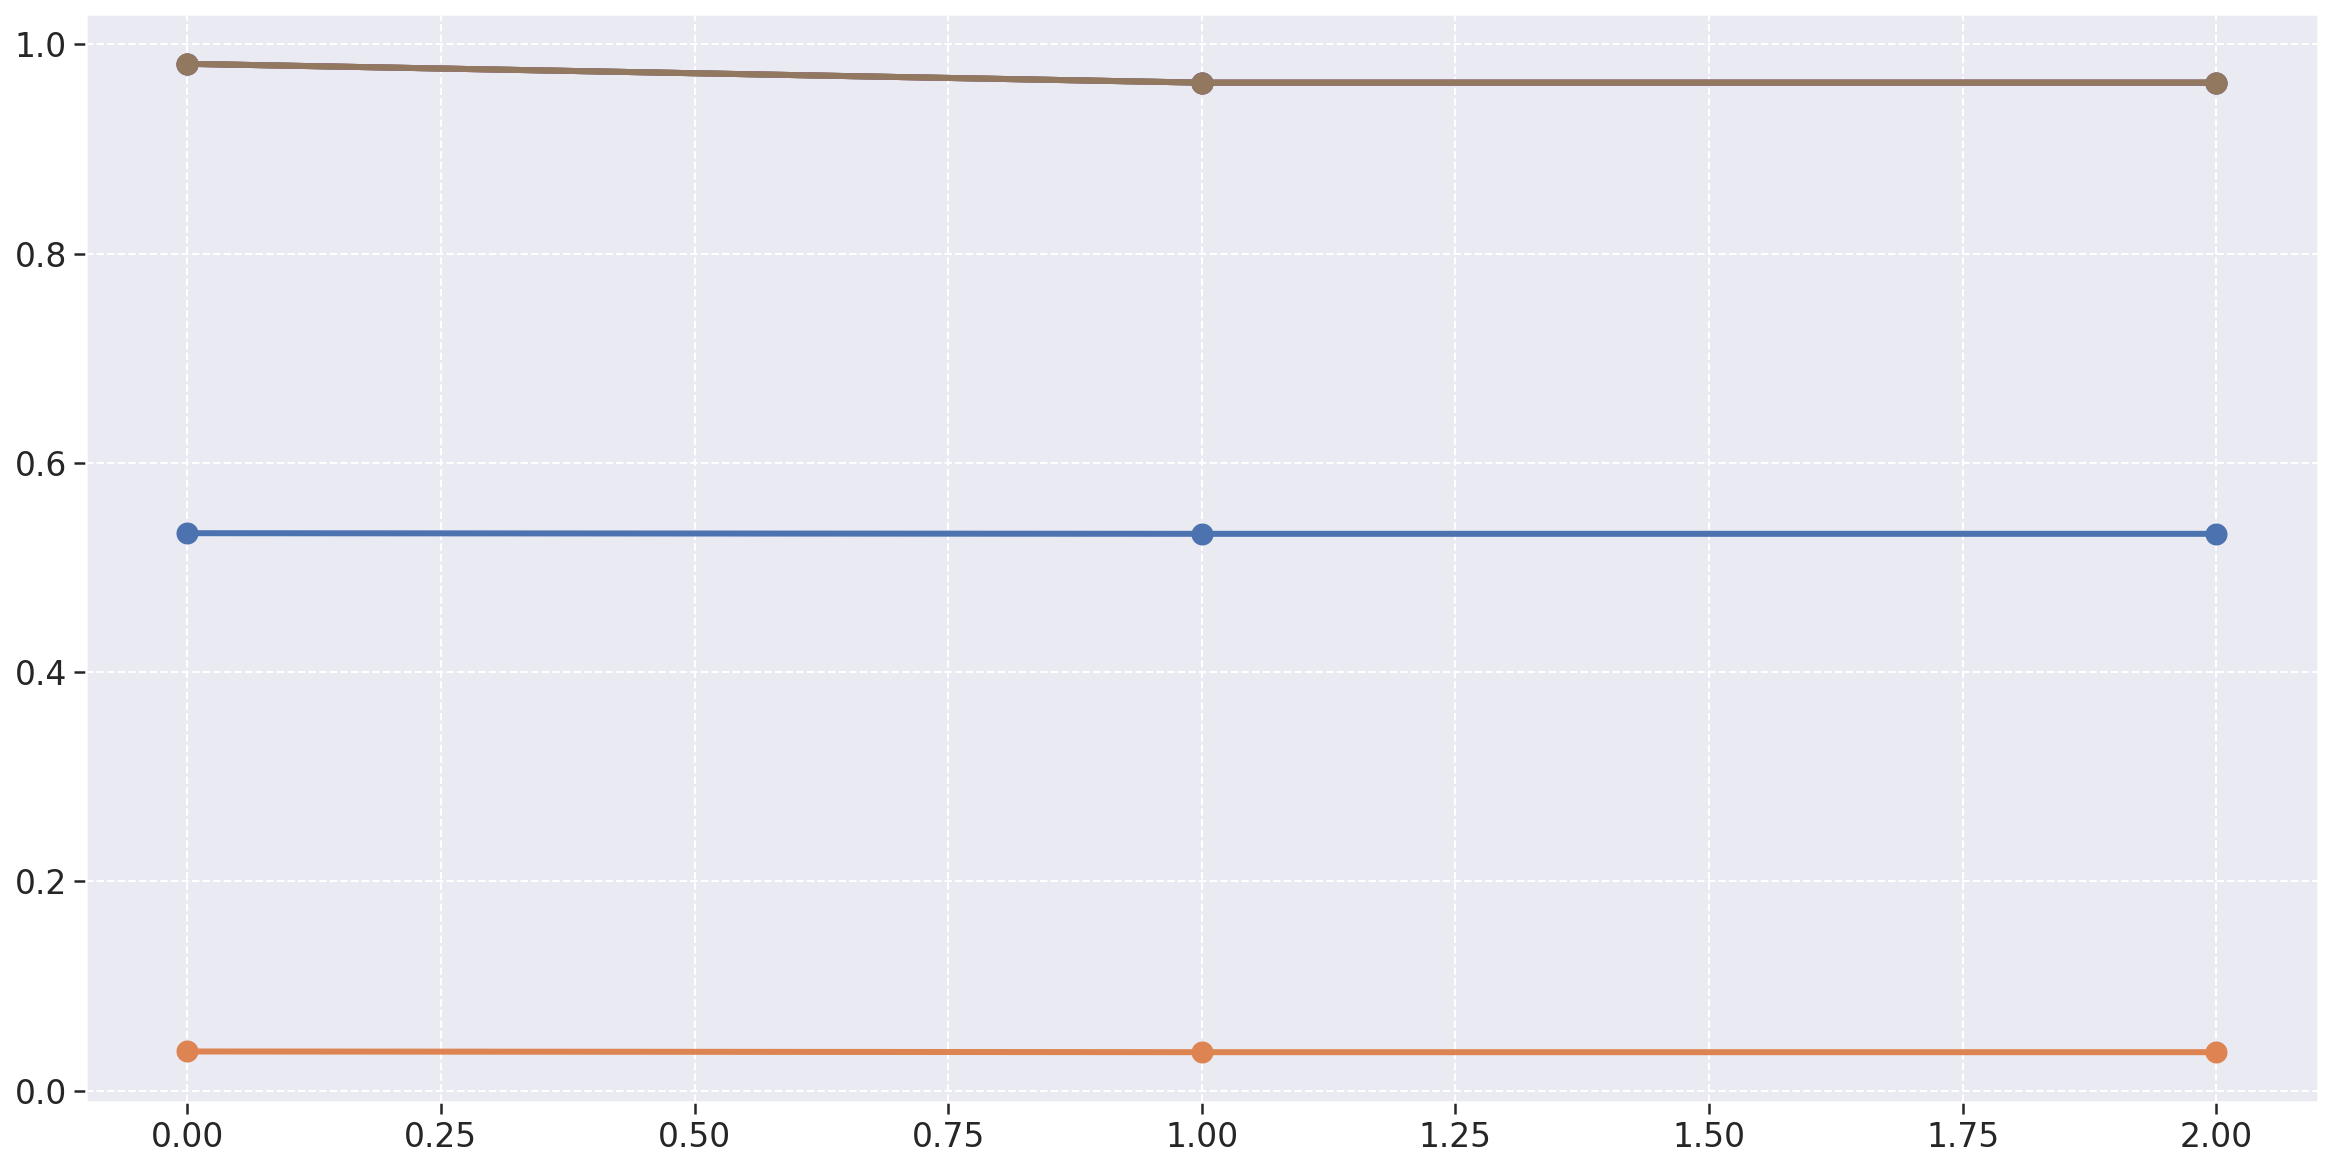

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot(front_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(front_metrics['m6'], linewidth=3, marker='o', markersize=10)

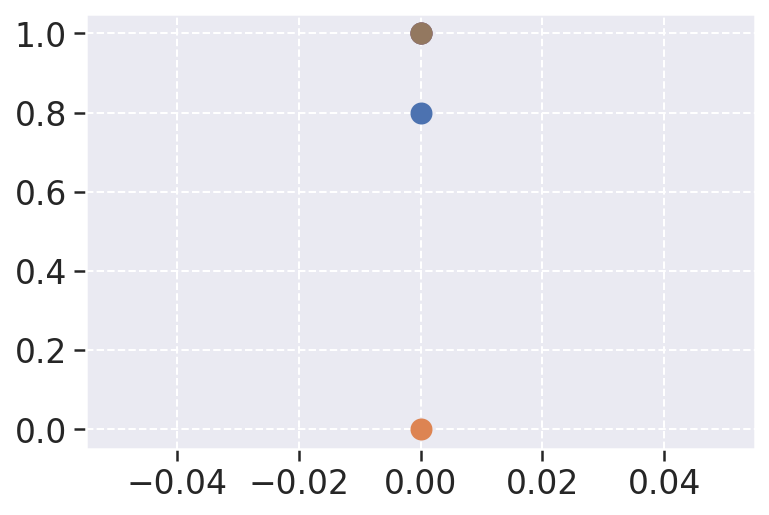

In [ ]:
plt.plot(profile_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(profile_metrics['m6'], linewidth=3, marker='o', markersize=10)

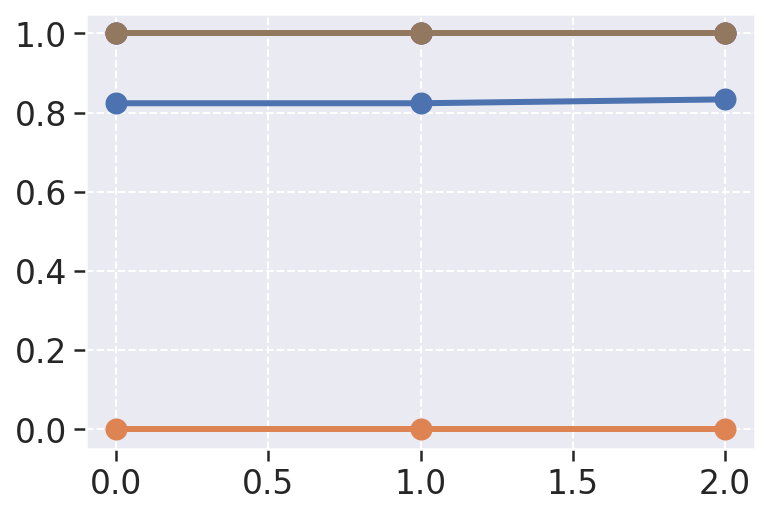

In [ ]:
plt.plot(registros_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(registros_metrics['m6'], linewidth=3, marker='o', markersize=10)

In [ ]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

front_metrics['code_quality'] = ((front_metrics['m1']*pm1) + (front_metrics['m2']*pm2) + (front_metrics['m3']*pm3)) * psc1
profile_metrics['code_quality'] = ((profile_metrics['m1']*pm1) + (profile_metrics['m2']*pm2) + (profile_metrics['m3']*pm3)) * psc1
registros_metrics['code_quality'] = ((registros_metrics['m1']*pm1) + (registros_metrics['m2']*pm2) + (registros_metrics['m3']*pm3)) * psc1


front_metrics['testing_status'] = ((front_metrics['m4']*pm4) + (front_metrics['m5']*pm5) + (front_metrics['m6']*pm6)) * psc2
profile_metrics['testing_status'] = ((profile_metrics['m4']*pm4) + (profile_metrics['m5']*pm5) + (profile_metrics['m6']*pm6)) * psc2
registros_metrics['testing_status'] = ((registros_metrics['m4']*pm4) + (registros_metrics['m5']*pm5) + (registros_metrics['m6']*pm6)) * psc2

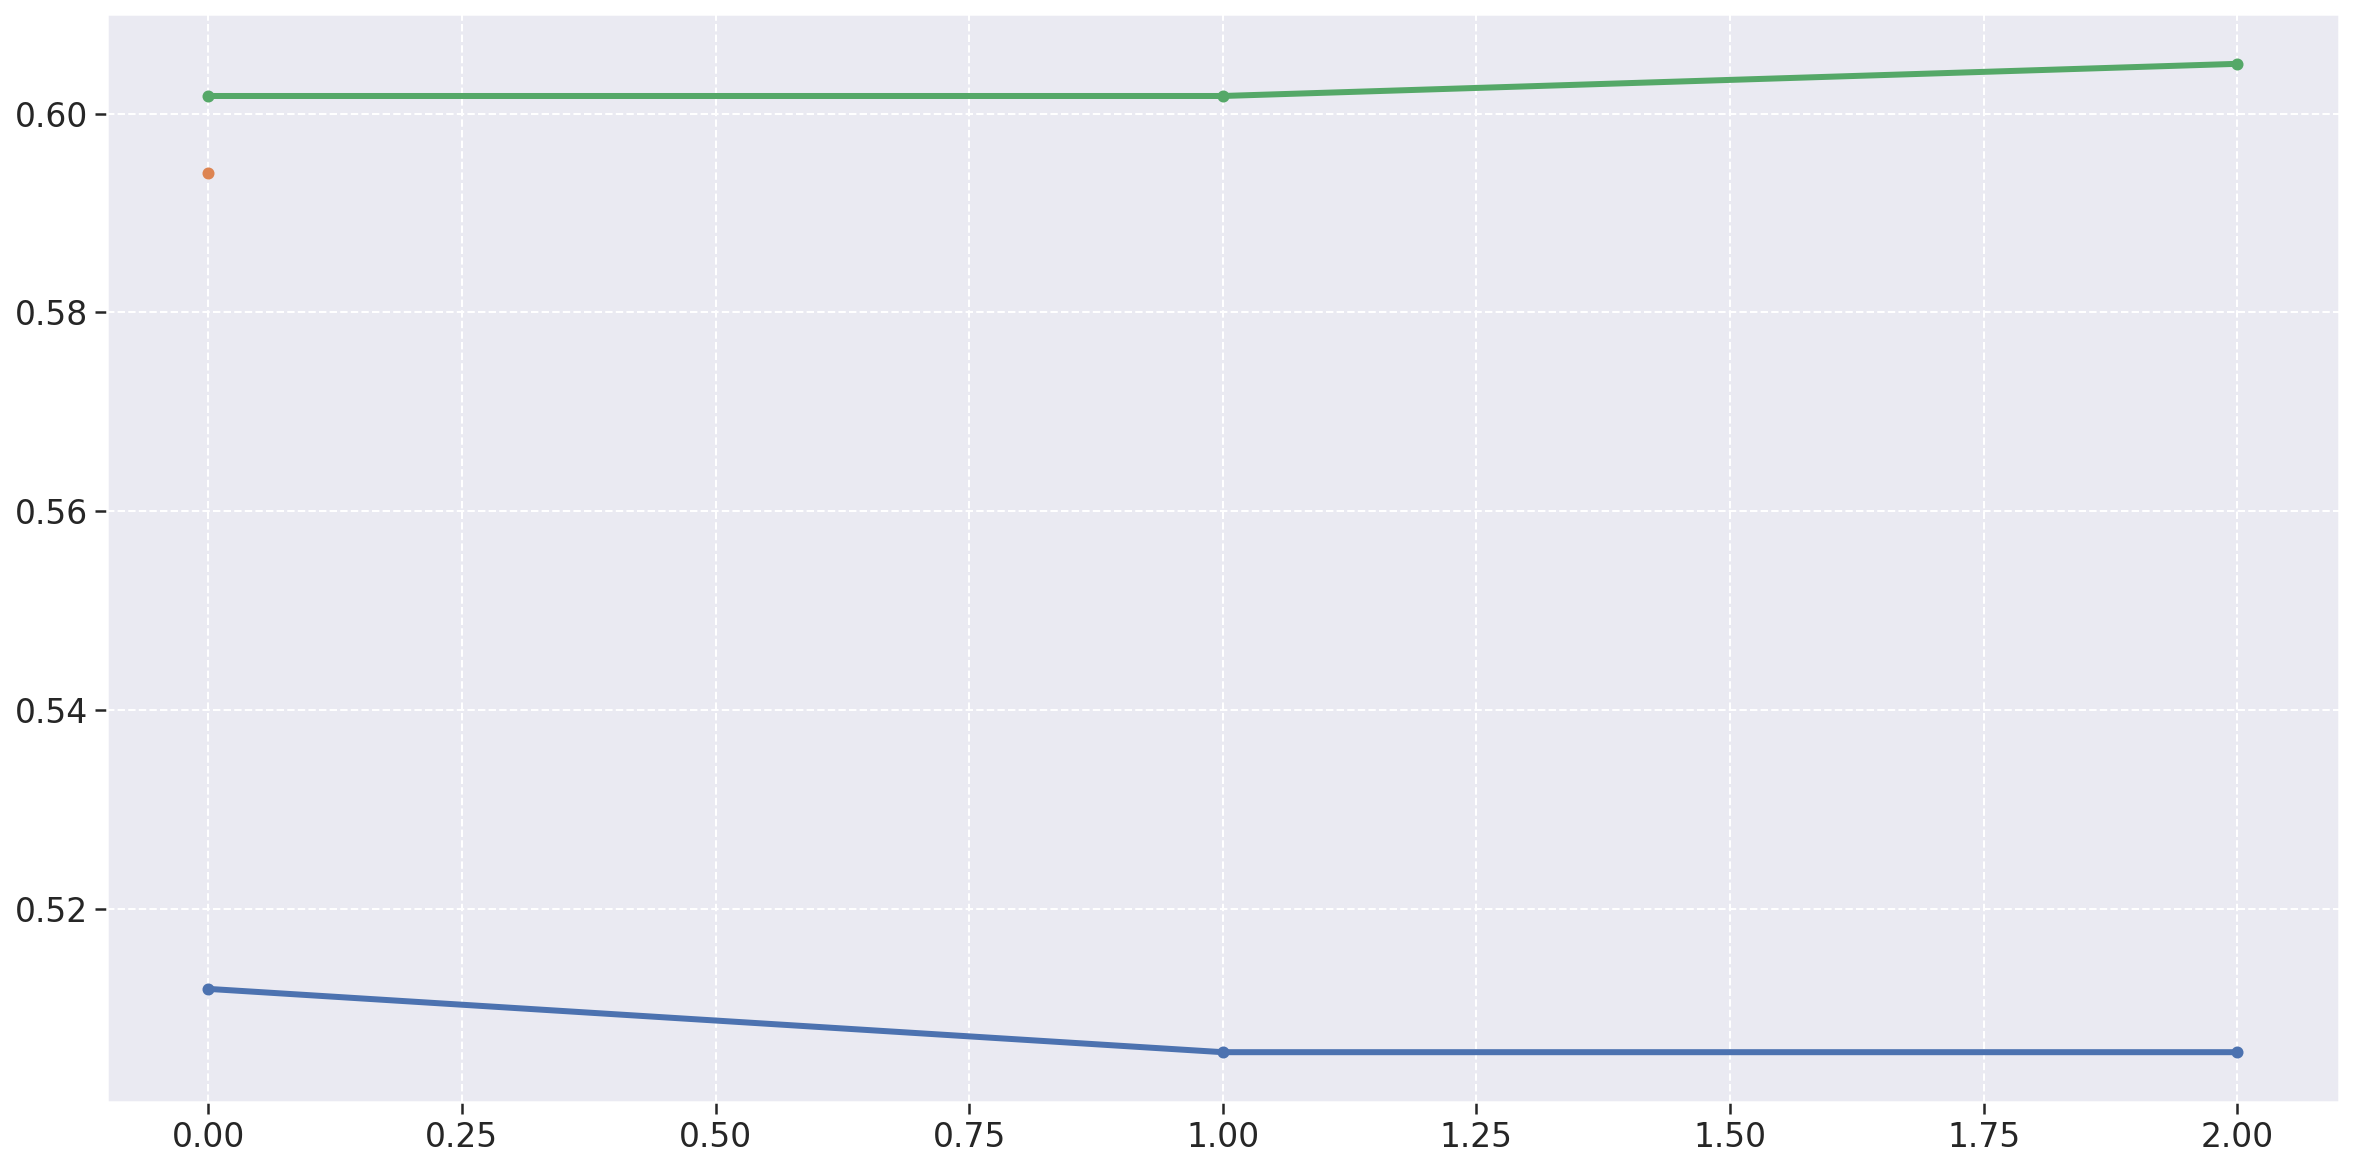

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(front_metrics['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(profile_metrics['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(registros_metrics['code_quality'], linewidth=3, marker='o', markersize=5)

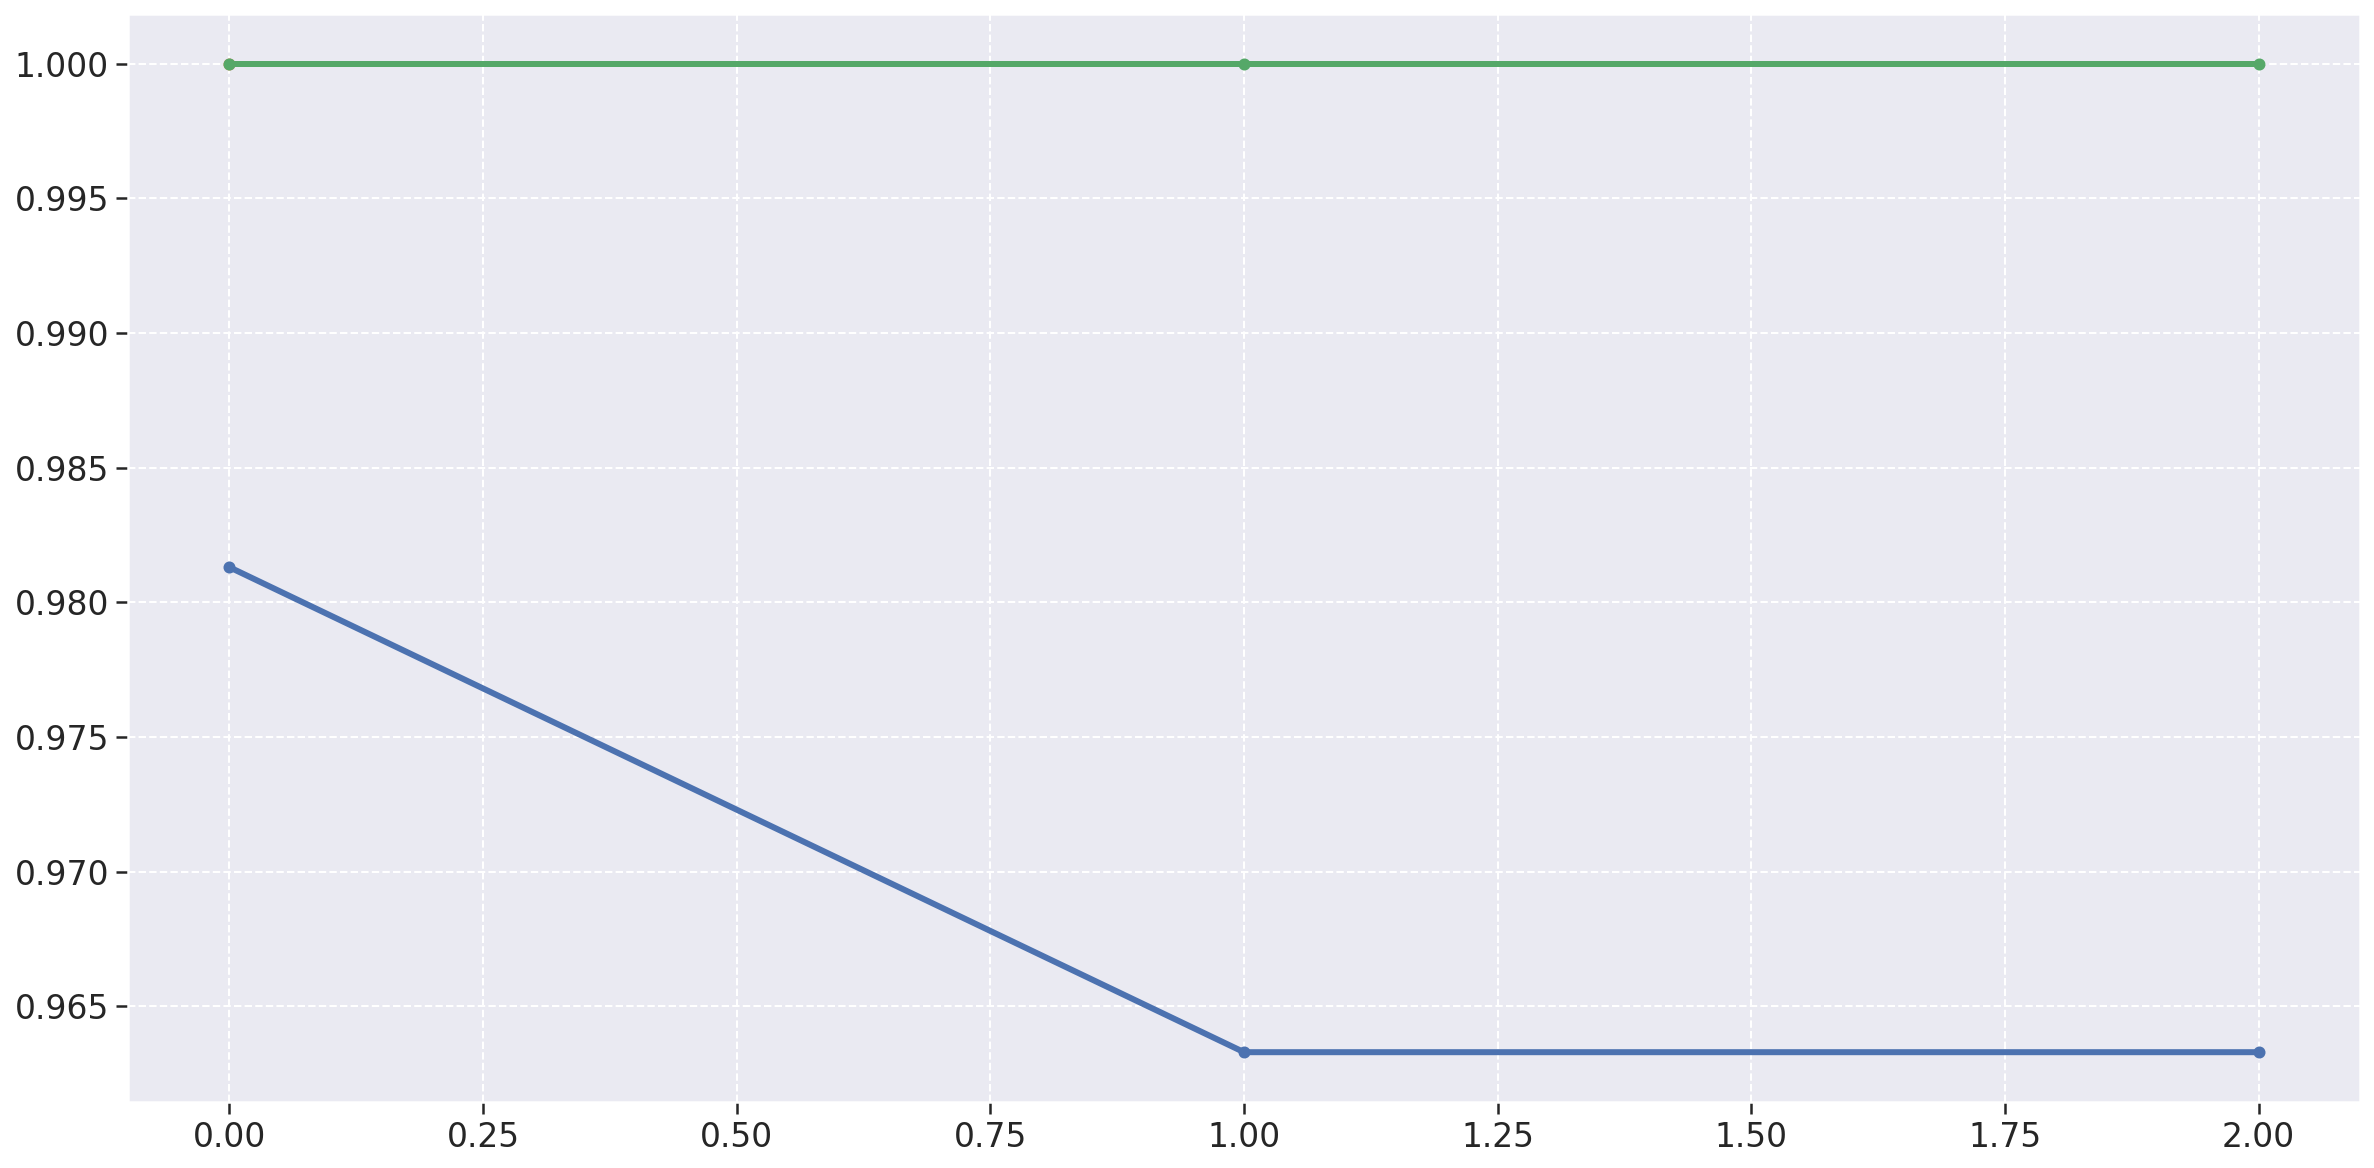

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(front_metrics['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(profile_metrics['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(registros_metrics['testing_status'], linewidth=3, marker='o', markersize=5)

In [ ]:
metrics_df = pd.concat([front_metrics, profile_metrics, registros_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [ ]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,0.532710,0.037383,0.981308,0.981308,0.981308,0.981308,FrontEnd,03-25-2022-23-14-35-v3.0.7,6981,0.511963,0.981308,0.255981,0.490654,0.746636
1,0.532110,0.036697,0.963303,0.963303,0.963303,0.963303,FrontEnd,04-01-2022-10-41-30-v3.1.0,7144,0.505596,0.963303,0.252798,0.481651,0.734450
2,0.532110,0.036697,0.963303,0.963303,0.963303,0.963303,FrontEnd,04-08-2022-12-56-05-v3.2.0,7220,0.505596,0.963303,0.252798,0.481651,0.734450
3,0.800000,0.000000,1.000000,1.000000,1.000000,1.000000,Profile,03-27-2022-18-59-14-v3.3.1,479,0.594000,1.000000,0.297000,0.500000,0.797000
4,0.823529,0.000000,1.000000,1.000000,1.000000,1.000000,Registros,03-26-2022-18-26-26-v4.5.2,978,0.601765,1.000000,0.300882,0.500000,0.800882
5,0.823529,0.000000,1.000000,1.000000,1.000000,1.000000,Registros,04-01-2022-10-42-10-v4.6.0,984,0.601765,1.000000,0.300882,0.500000,0.800882
6,0.833333,0.000000,1.000000,1.000000,1.000000,1.000000,Registros,04-08-2022-12-57-08-v4.7.0,1062,0.605000,1.000000,0.302500,0.500000,0.802500


(0.45, 0.7)

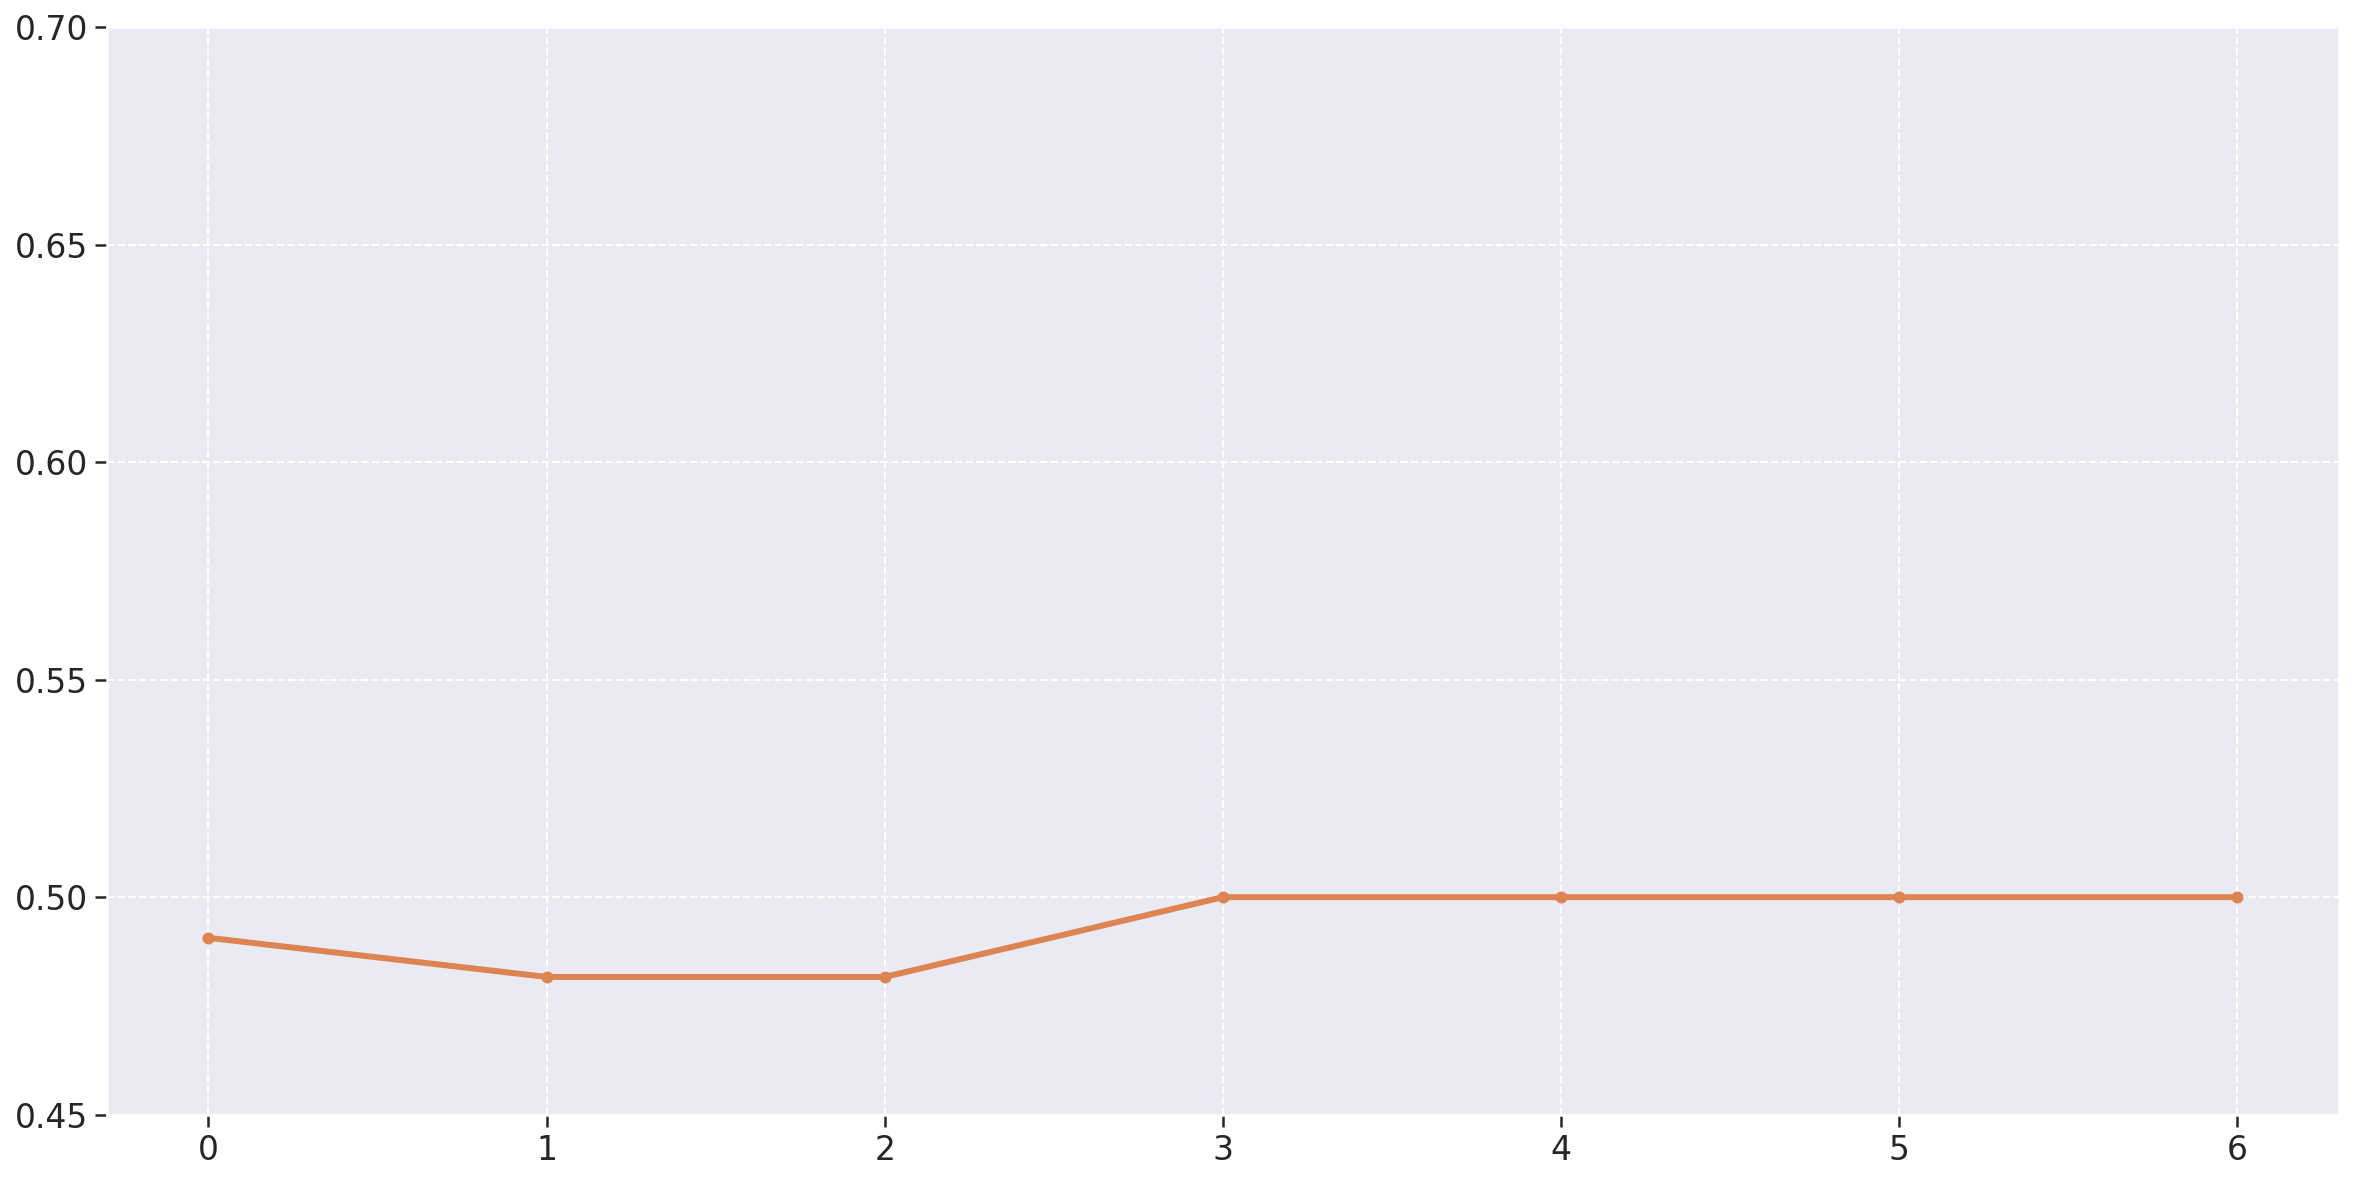

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5)


plt.ylim(.45,.7)

(0.45, 0.7)

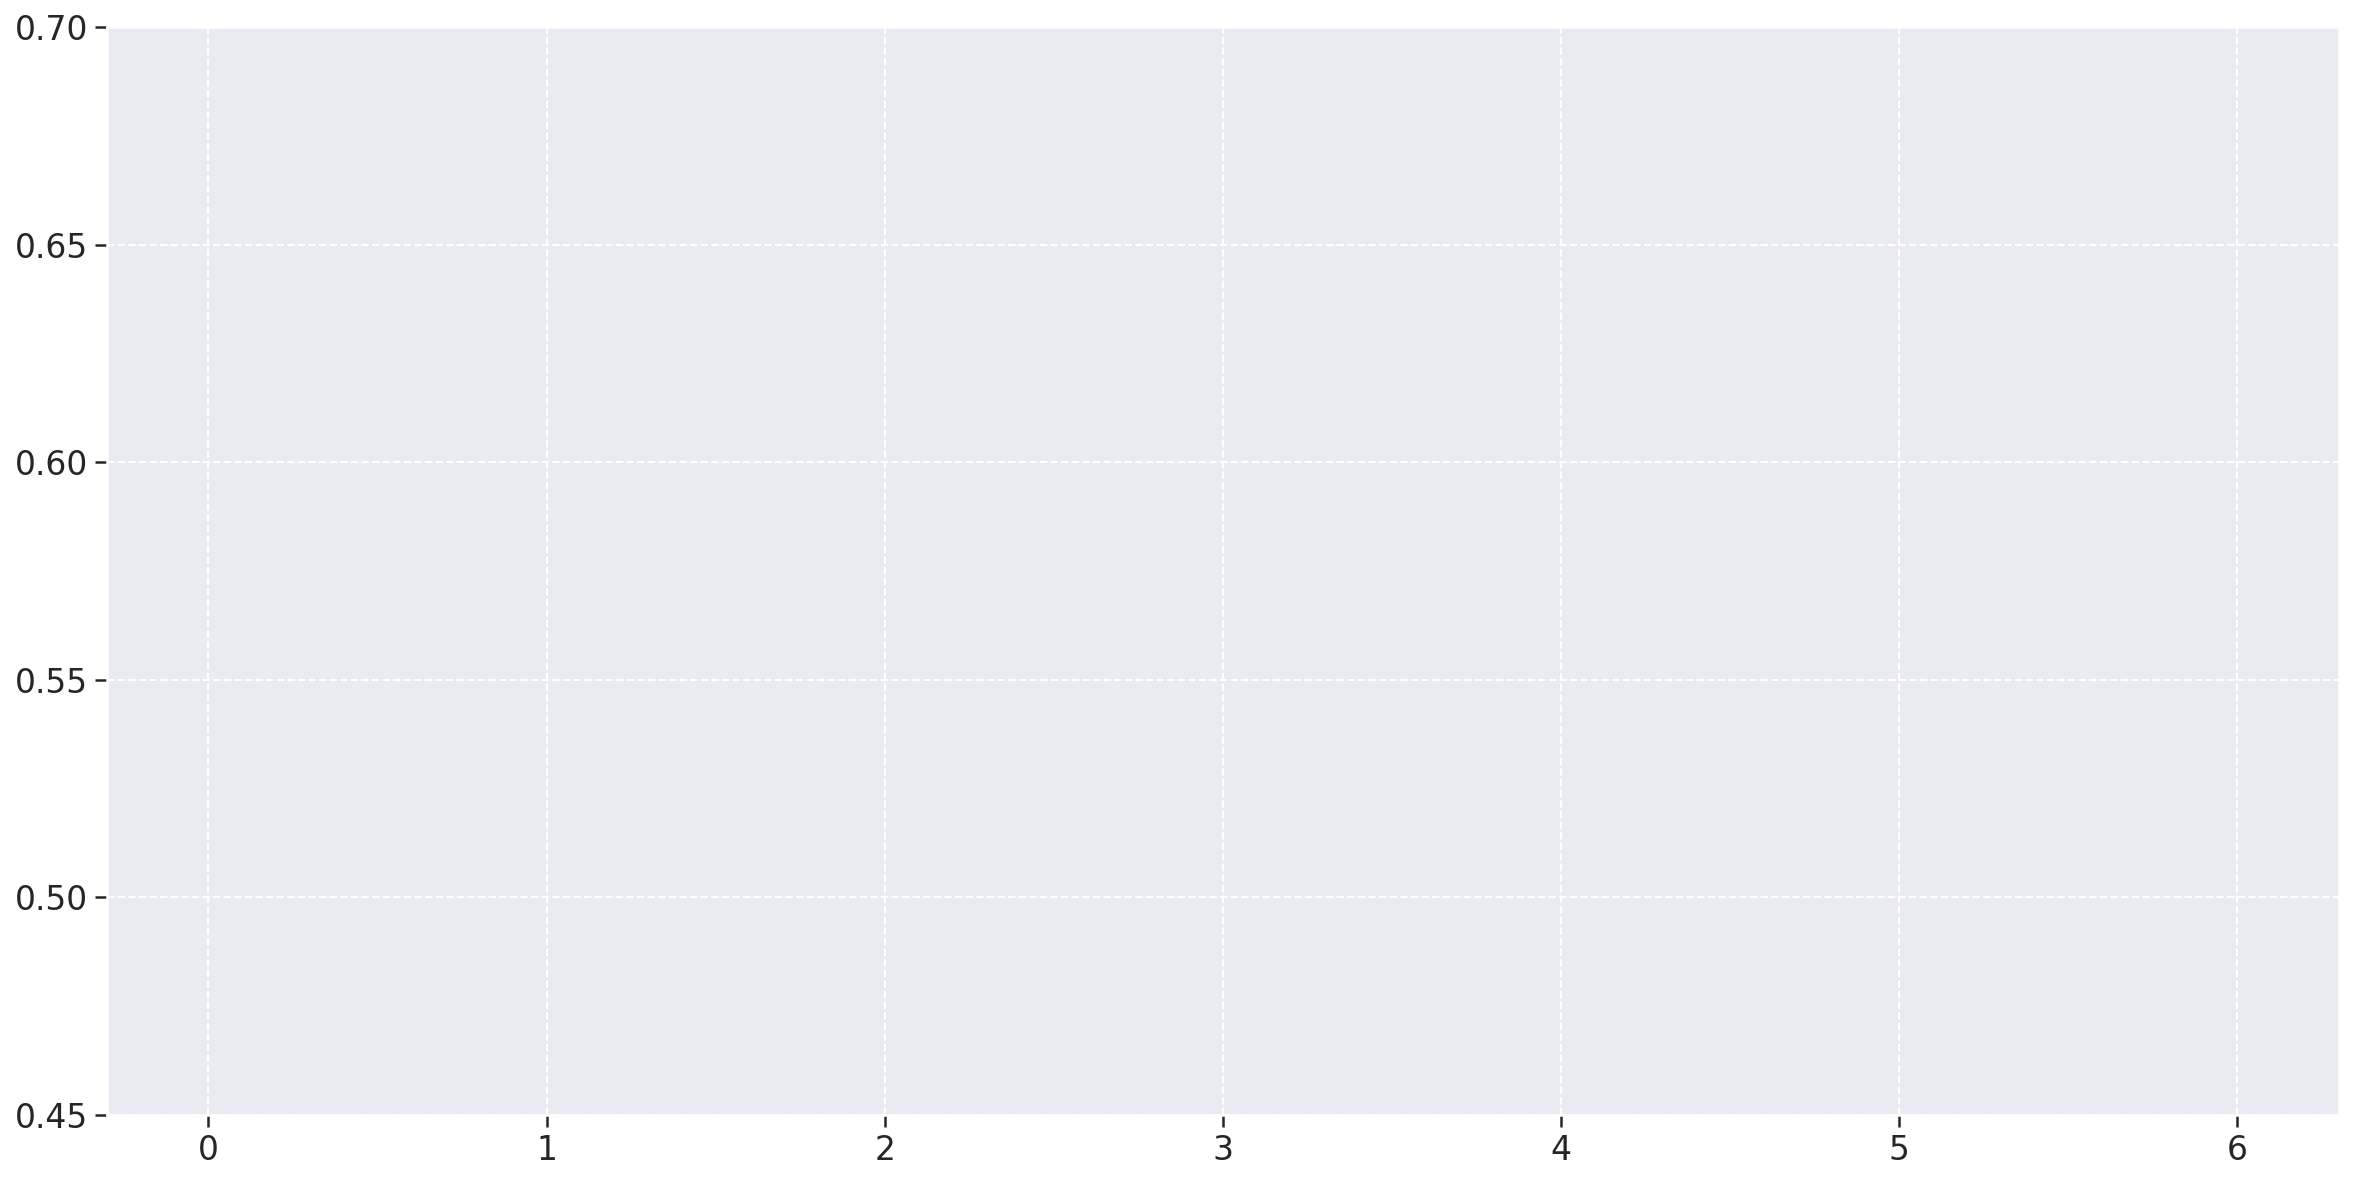

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)


plt.ylim(.45,.7)

In [ ]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_excel('../data/fga-eps-mds-2021-2-Oraculo-DATASET-{}.xlsx'.format(currentDateTime), index = False)
metrics_df.to_csv('../data/fga-eps-mds-2021-2-Oraculo-DATASET-{}.csv'.format(currentDateTime), index = False)